In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from srresnet import _NetG

%matplotlib inline

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as tf
from torch.utils.data import Dataset, DataLoader

In [3]:
class SRDataset(Dataset):
    def __init__(self,root, cropsize=512, downsample_factor=4):
        self.imagefolder = ImageFolder(root,transform=tf.RandomCrop(cropsize))
        self.cropsize = cropsize
        self.ds_size = int(cropsize/downsample_factor)
    
    def __len__(self):
        return len(self.imagefolder)
    def __getitem__(self,idx):
        HR_img,_ = self.imagefolder[idx]
        LR_img = tf.Resize(size=self.ds_size)(HR_img)
        tt = tf.ToTensor()
        return (tt(LR_img),tt(HR_img))
    

In [4]:
import argparse
import math, random
import os, time

In [5]:
from SR_options import TestOptions
from SRGAN_models import SRGANS, SR_WGANS

In [6]:
opt = TestOptions().parse(['--name','SRGANs_1000','--checkpoints_dir','./checkpoint'])

----------------- Options ---------------
          checkpoints_dir: ./checkpoint                  
                    epoch: latest                        
                  gpu_ids: 0                             
                  isTrain: False                         	[default: None]
                     name: SRGANs_1000                   	[default: experiment_name]
                   suffix:                               
----------------- End -------------------


In [40]:
model = SRGANS(opt)

loading the model from ./checkpoint/SRGANs_1000/latest_net_G.pth


In [18]:
for data in data_loader:
    with torch.no_grad():
        model.set_input(data)
        model.forward()
    break

# Plot Val losses

In [6]:
import glob

In [7]:
paths = glob.glob('./checkpoint/*/val_losses.npy')
val_losses = {}
for path in paths:
    # load val_losses
    key = path[path.find('nt/')+3:path.find('/val')]
    val_losses[key] = np.load(path)
print(paths)

['./checkpoint/SR_WGANs_500/val_losses.npy', './checkpoint/SR_WGANs_500_noDNorm/val_losses.npy', './checkpoint/SR_WGANs_1000_noDNorm/val_losses.npy', './checkpoint/SR_WGANs_1000/val_losses.npy', './checkpoint/SRGANs_ImagePool_lam500/val_losses.npy', './checkpoint/SRGANs_1000/val_losses.npy']


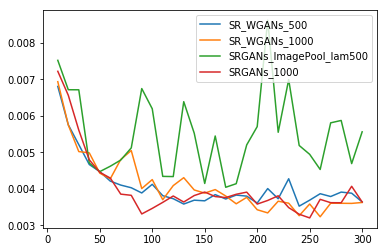

In [18]:
for key in val_losses:
    if key.find('noDNorm') == -1:
        plt.plot(np.arange(10,301,10),val_losses[key].mean(axis=1),label=key)
plt.legend(loc=0)
    

In [19]:
model_names = [key for key in val_losses]# if key.find('noDNorm')]

# Test on set5

In [26]:
def get_results(model_names,imgs):
    lr,hr = imgs
    c, h, w = lr.size()
    
    opt = TestOptions().parse([])
    
    results = np.zeros((len(model_names),4*h,4*w,c),dtype=np.uint8)
    for i,model_name in enumerate(model_names):
        opt.name = model_name
        model = SRGANS(opt)
        results[i] = ten2np(model.test_single(lr))
        
        del model
        torch.cuda.empty_cache()
    return results

def ten2np(img):
    return np.asarray(tf.ToPILImage()(img))

def mse(a,b):
    return np.power(a-b,2).mean()

def get_mse_result(img):
    # optionally resume from a checkpoint
    model = _NetG(tanh=False)
    
    pathtomodel = './checkpoint/MSELoss/latest_net_G.pth'
    if os.path.isfile(pathtomodel):
        checkpoint = torch.load(pathtomodel)
        model.load_state_dict(checkpoint["model"].state_dict())

        model = model.cuda()
        
        with torch.no_grad():
            sr = ten2np(model(img.unsqueeze(0).cuda()).cpu()[0])
        
        del model
        torch.cuda.empty_cache()
        return sr
def get_bicubic(data):
    lr,hr = data
    _,h,w = hr.size()
    return np.asarray(tf.Compose([tf.ToPILImage(),tf.Resize(size=(h,w),interpolation=3)])(lr))

In [10]:
class SRSet5Dataset(Dataset):
    def __init__(self,root,  downsample_factor=4):
        self.imagefolder = ImageFolder(root)
        self.ds = downsample_factor
    
    def __len__(self):
        return len(self.imagefolder)
    def __getitem__(self,idx):
        HR_img,_ = self.imagefolder[idx]
        h,w = HR_img.size
        
        
        LR_img = tf.functional.resize(HR_img, size=(int(h/self.ds),int(w/self.ds)))
        tt = tf.ToTensor()
        return (tt(LR_img),tt(HR_img))
    

In [11]:
dataset = SRSet5Dataset('./data/test/')
model_names = [path[path.find('nt/')+3:path.find('/val')] for path in glob.glob('./checkpoint/*/val_losses.npy')]# if path.find('noDNorm')==-1]
#model_names.append('MSELoss')
print(model_names)

['SR_WGANs_500', 'SR_WGANs_500_noDNorm', 'SR_WGANs_1000_noDNorm', 'SR_WGANs_1000', 'SRGANs_ImagePool_lam500', 'SRGANs_1000']


----------------- Options ---------------
          checkpoints_dir: ./checkpoint                  
                    epoch: latest                        
                  gpu_ids: 0                             
                  isTrain: False                         	[default: None]
                     name: experiment_name               
                   suffix:                               
----------------- End -------------------
loading the model from ./checkpoint/SR_WGANs_500/latest_net_G.pth
loading the model from ./checkpoint/SR_WGANs_500_noDNorm/latest_net_G.pth
loading the model from ./checkpoint/SR_WGANs_1000_noDNorm/latest_net_G.pth
loading the model from ./checkpoint/SR_WGANs_1000/latest_net_G.pth
loading the model from ./checkpoint/SRGANs_ImagePool_lam500/latest_net_G.pth
loading the model from ./checkpoint/SRGANs_1000/latest_net_G.pth


/nv/hp20/jjin77/.conda/envs/py-torch/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'srresnet._NetG' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/nv/hp20/jjin77/.conda/envs/py-torch/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'srresnet._Residual_Block' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


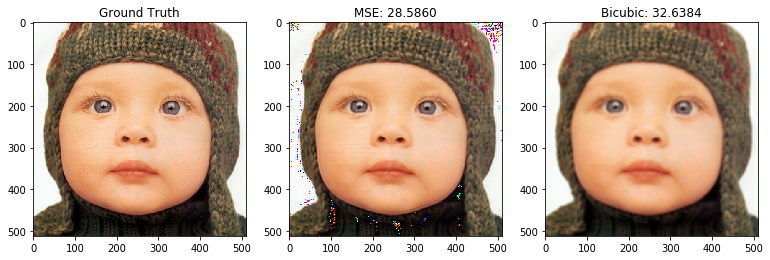

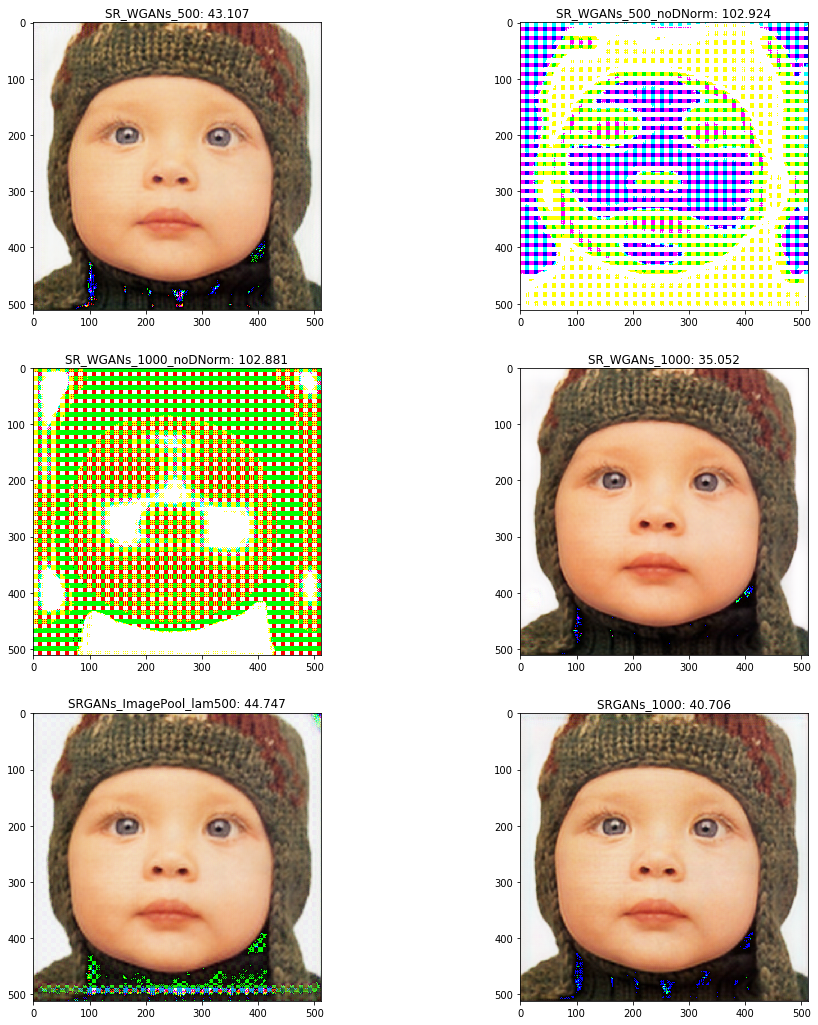

In [27]:
test_img = 0
sr_0 = get_results(model_names,dataset[test_img])
mse_sr = get_mse_result(dataset[test_img][0])
bicubic = get_bicubic(dataset[test_img])

plt.figure(figsize=(13,8))
hr = ten2np(dataset[0][1])
plt.subplot(131)
plt.imshow(hr)
plt.title('Ground Truth')
plt.subplot(132)
plt.imshow(mse_sr)
plt.title('MSE: %.4f' % mse(hr,mse_sr))
plt.subplot(133)
plt.imshow(bicubic)
plt.title('Bicubic: %.4f' % mse(hr,bicubic))


plt.figure(figsize=(16,18))
for i in range(3):
    #plt.figure(figsize=(8,8))
    for j in range(2):
        idx = i*2 + j
        plt.subplot(3,2,idx+1)
        plt.imshow(sr_0[idx])
        plt.title(model_names[idx] + ": %.3f" % (mse(hr,sr_0[idx])))

----------------- Options ---------------
          checkpoints_dir: ./checkpoint                  
                    epoch: latest                        
                  gpu_ids: 0                             
                  isTrain: False                         	[default: None]
                     name: experiment_name               
                   suffix:                               
----------------- End -------------------
loading the model from ./checkpoint/SR_WGANs_500/latest_net_G.pth
loading the model from ./checkpoint/SR_WGANs_500_noDNorm/latest_net_G.pth
loading the model from ./checkpoint/SR_WGANs_1000_noDNorm/latest_net_G.pth
loading the model from ./checkpoint/SR_WGANs_1000/latest_net_G.pth
loading the model from ./checkpoint/SRGANs_ImagePool_lam500/latest_net_G.pth
loading the model from ./checkpoint/SRGANs_1000/latest_net_G.pth


/nv/hp20/jjin77/.conda/envs/py-torch/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'srresnet._NetG' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/nv/hp20/jjin77/.conda/envs/py-torch/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'srresnet._Residual_Block' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


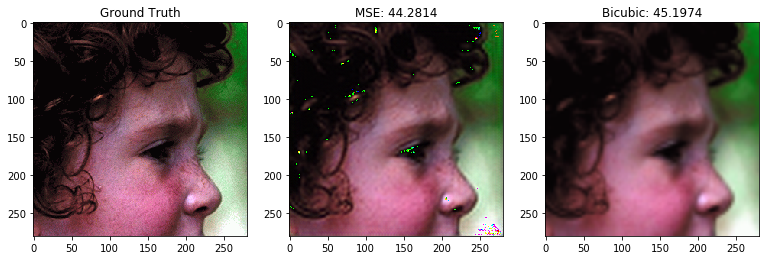

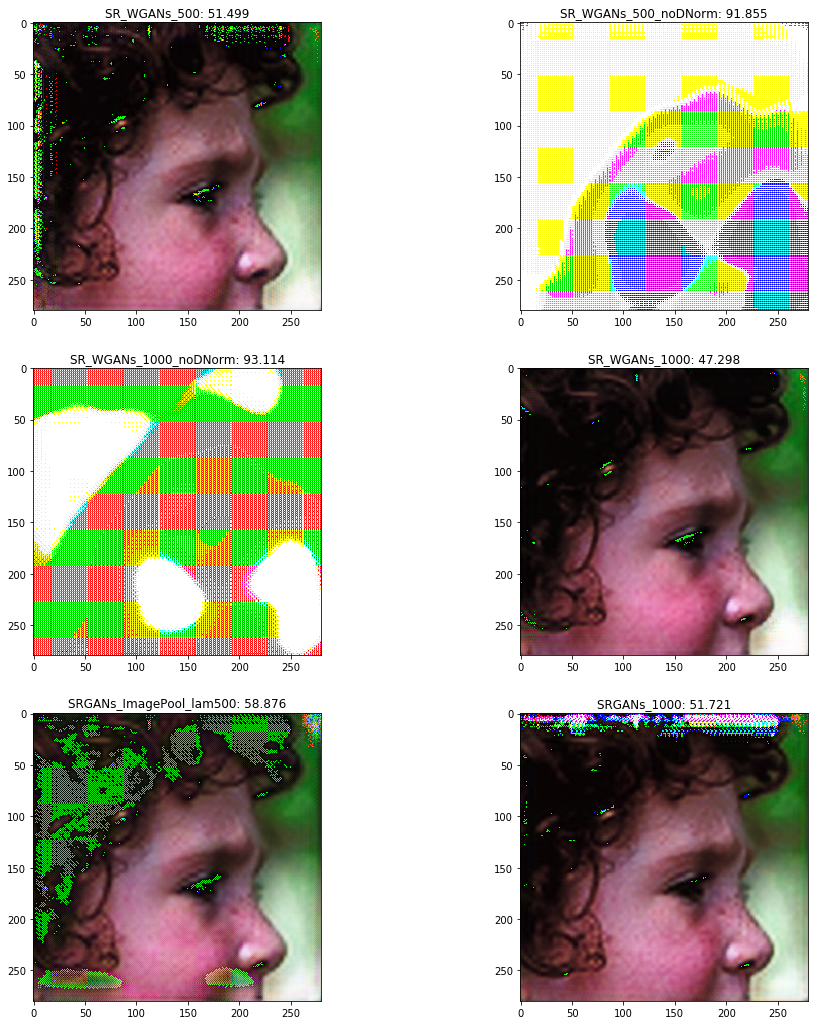

In [32]:
test_img = 3
hr = ten2np(dataset[test_img][1])
sr_0 = get_results(model_names,dataset[test_img])
mse_sr = get_mse_result(dataset[test_img][0])
bicubic = get_bicubic(dataset[test_img])

plt.figure(figsize=(13,8))
plt.subplot(131)
plt.imshow(hr)
plt.title('Ground Truth')
plt.subplot(132)
plt.imshow(mse_sr)
plt.title('MSE: %.4f' % mse(hr,mse_sr))
plt.subplot(133)
plt.imshow(bicubic)
plt.title('Bicubic: %.4f' % mse(hr,bicubic))


plt.figure(figsize=(16,18))
for i in range(3):
    #plt.figure(figsize=(8,8))
    for j in range(2):
        idx = i*2 + j
        plt.subplot(3,2,idx+1)
        plt.imshow(sr_0[idx])
        plt.title(model_names[idx] + ": %.3f" % (mse(hr,sr_0[idx])))

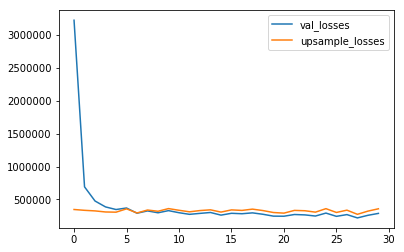

In [19]:
plt.figure()
plt.plot(validation_losses,label='val_losses')
plt.plot(upsample_losses,label='upsample_losses')

plt.legend(loc=0)

In [28]:
def ten2np(img):
    return np.asarray(tf.ToPILImage()(img))

bicubic = tf.Compose([tf.ToPILImage(),tf.Resize(size=512,interpolation=3)])
upsample = lambda x: np.asarray(bicubic(x))

In [29]:
# optionally resume from a checkpoint
model = _NetG()

if opt.resume:
    if os.path.isfile(opt.resume):
        print("=> loading checkpoint '{}'".format(opt.resume))
        checkpoint = torch.load(opt.resume)
        opt.start_epoch = checkpoint["epoch"] + 1
        model.load_state_dict(checkpoint["model"].state_dict())

model = model.cuda()

=> loading checkpoint './checkpoint/model_epoch_300.pth'


In [30]:
lr,hr = dataset[0]
lr = lr.unsqueeze(0).cuda()

hr_hat = model(lr).cpu()
lr = lr[0].cpu()

In [35]:
hr_hat.size(), hr_hat.max(), hr_hat.min()

(torch.Size([1, 3, 512, 512]),
 tensor(1.0867, grad_fn=<MaxBackward1>),
 tensor(-0.0902, grad_fn=<MinBackward1>))

In [36]:
hr_img = ten2np(hr_hat[0])
print(hr_img.shape)

(512, 512, 3)


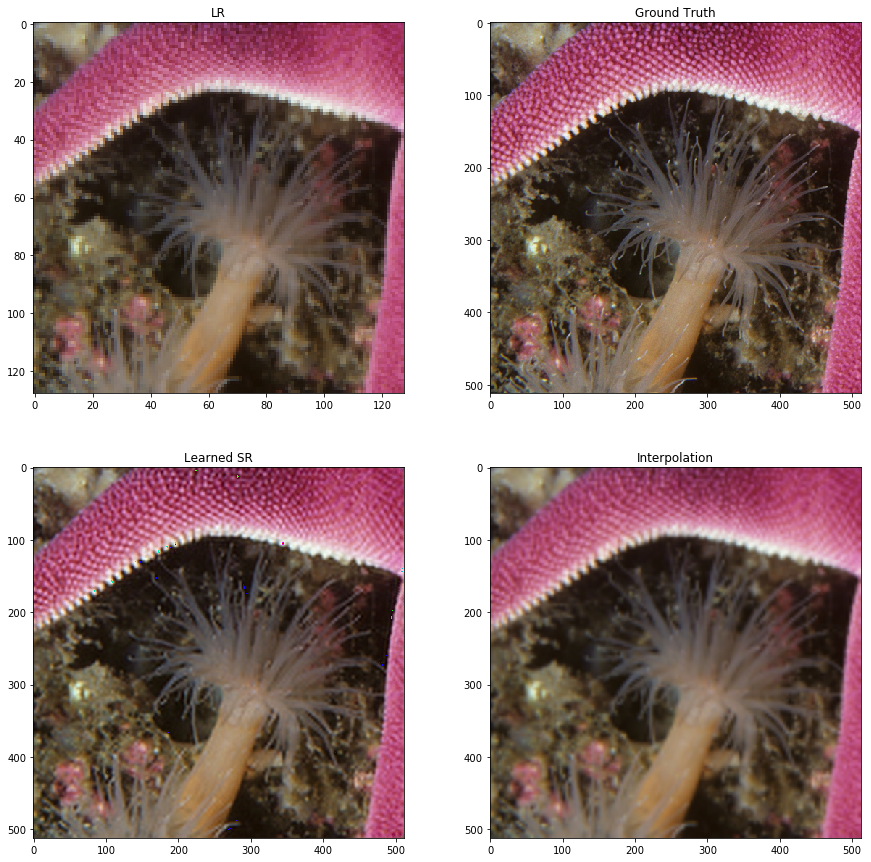

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(221)
#plt.figure(figsize=(10,10))
plt.imshow(ten2np(lr))
plt.title('LR')

plt.subplot(222)
#plt.figure(figsize=(10,10))
plt.title('Ground Truth')
plt.imshow(ten2np(hr))

plt.subplot(223)
#plt.figure(figsize=(10,10))
plt.imshow(hr_img)
plt.title('Learned SR')

plt.subplot(224)
#plt.figure(figsize=(10,10))
plt.imshow(upsample(lr))
plt.title('Interpolation')
